# Cross Validation

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import pandas as pd
from sklearn import preprocessing, pipeline, model_selection, linear_model, mixture
import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Model Selection With Cross Validation</span>

Recall that there are three main types of learning:
 - Learning model parameters from data.

 - Learning to predict new data (unsupervised learning).

 - Learning to predict target features in new data (supervised learning).

All three types of learning require an assumed model with associated parameters, and predicting new data is only possible after learning model parameters from old data.

Since all types of learning assume a model, they must all solve the meta-problem of comparing competing models. The Bayesian evidence $P(D\mid M)$ is our primary quantitative tool for comparing how well different models explain the same data.  When we are primarily interested in a model's ability to generalize and predict new data, ___<span style="color:violet">cross validation</span>___ is a useful alternative.

### <span style="color:Lightgreen">Train vs. Validate vs. Test Data</span>

During an ML model development and evaluation, various types of data are utilized. Below, we review these types of data, their purpose and the differences between each in how they are used.

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/CrossValidation-splits.png" width=800></img>
</div>

<span style="color:Tan">Training Dataset</span>: The sample of data used to fit the model.

* The actual dataset that we use to train the ML model under development (weights and biases in the case of a Neural Network). The model sees and learns from this data. Training data are collections of examples or samples that are used to "teach" or "train" the model. The model uses a training data set to understand the patterns and relationships within the data, thereby learning to make predictions or decisions without being explicitly programmed to perform a specific task.

<span style="color:Tan">Validation Dataset</span>: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset (i.e. a "trained model") while tuning model hyperparameters. The evaluation becomes more biased as more skill on the validation dataset is incorporated into the model configuration.

* It is still possible to tune and control the model at this stage. Working on validation data is used to assess the model performance and fine-tune the parameters of the model. This becomes an iterative process wherein the model learns from the training data and is then validated and fine-tuned on the validation set. A validation dataset tells us how well the model is learning and adapting, allowing for adjustments and optimizations to be made to the model's parameters or hyperparameters before it's finally put to the test. So the validation set affects a model, but only indirectly.

  * Note that not all models require validation sets. Some experts consider that ML models with no hyperparameters or those that do not have tuning options do not need a validation set. Still, in most practical applications, validation sets play a crucial role in ensuring the model's robustness and performance.

<span style="color:Tan">Test Dataset</span>: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

* The Test dataset provides the gold standard used to evaluate the model. It is only used once a model is completely trained (using the train and validation sets). It is a separate sample, an unseen data set, to provide an unbiased final evaluation of a model. Its primary purpose is to offer a fair and final assessment of how the model would perform when it encounters new data in a live, operational environment.

  * The test set is generally what is used to evaluate competing models (For example on many Kaggle competitions, the validation set is released initially along with the training set and the actual test set is only released when the competition is about to close, and it is the result of the the model on the Test set that decides the winner).

  * Many a times the validation set is used as the test set, but it is not good practice. The test set is generally well curated. It contains carefully sampled data that spans the various classes that the model would face, when used in the real world on data it has never seen before. The inputs in the test data are similar to the previous stages but not the same data.

### <span style="color:Lightgreen">Cross Validation (CV) Process</span>

Cross validation is a process that provides the ability to estimate model performance on unseen data not used while training. It is a systematic process that can involve tuning the model hyperparameters, testing different properties of the overall datasets, and iterating the training process. There are many variations of the CV process - we will study primarily the <span style="color:violet">K-folds method</span> in this lecture. We will show some examples using random sampling (called "folds") of these types of data to illustrate the process. For simplicity, we will focus on the test and train data and not consider validation data explicitly in the following.

The figure below summarizes the data splitting and process:

<div>
<img src="https://raw.githubusercontent.com/illinois-ipaml/MachineLearningForPhysics/main/img/CrossValidation-process.png" width=600></img>
</div>

The basic idea of ___<span style="color:violet">cross validation</span>___ is to:
1. split the observed data into separate training and test datasets

2. learn the model from the training dataset

3. measure the model's ability to predict the test dataset

4. repeat the steps above with different splits ("folds") and combine the results.

### <span style="color:Lightgreen">Overfitting and Generalization</span>

Generate some data consisting of 2D points along the path of a projectile, where $x$ is measured with negligible error and $y$ has a known error $\sigma_y$:

In [20]:
xlo, xhi = 0., 1.
poly_coefs = np.array([-1., 2., -1.])
f = lambda X: np.dot(poly_coefs, [X ** 0, X ** 1, X ** 2])
sigma_y = 0.2

In [21]:
def generate(N, seed=123):
    gen = np.random.RandomState(seed=seed)
    X = gen.uniform(xlo, xhi, size=N)
    y = f(X) + gen.normal(scale=sigma_y, size=N)
    return X, y

Compare results with different numbers of samples from the same model:

In [22]:
Xa, ya = generate(N=15)
Xb, yb = generate(N=150)

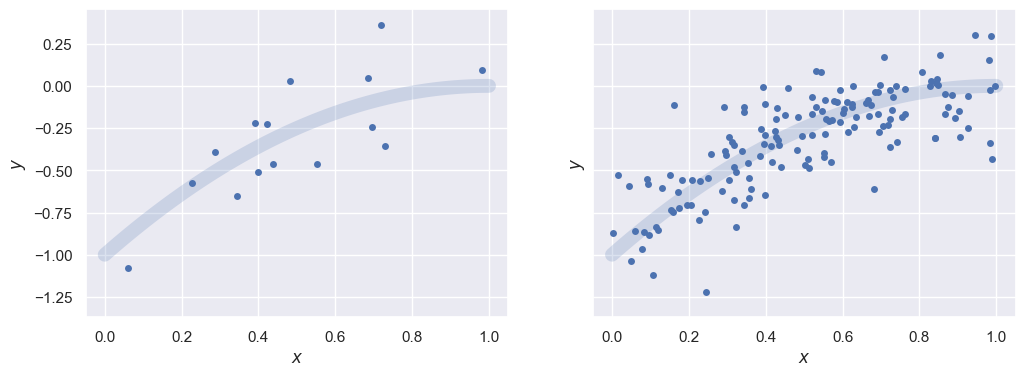

In [23]:
def plotXy(X, y, ax=None, *fits):
    ax = ax or plt.gca()
    ax.scatter(X, y, s=25, lw=0)
    x_grid = np.linspace(xlo, xhi, 100)
    ax.plot(x_grid, f(np.array(x_grid)), '-', lw=10, alpha=0.2)
    for fit in fits:
        y_fit = fit.predict(x_grid.reshape(-1, 1))
        ax.plot(x_grid, y_fit, lw=2, alpha=1)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ylo, yhi = np.percentile(y, (0, 100))
    dy = yhi - ylo
    ax.set_ylim(ylo - 0.1 * dy, yhi + 0.1 * dy)

_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plotXy(Xa, ya, ax[0])
plotXy(Xb, yb, ax[1])

The family of competing models we consider are polynomials of different degrees $P$,

$$ \Large
y(x) = \sum_{k=0}^P\, c_k x^k \; ,
$$

each with $P+1$ parameters.  The true model that the datasets were generated from have $P=2$.

Use sklearn [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to implement this fit after expanding the features with [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html),

$$ \Large
x \; \rightarrow\; \{ x^0, x^1, \ldots, x^P \} \; ,
$$

and combining the preprocessing and regression steps into a [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

In [24]:
def poly_fit(X, y, degree):
    degree_is_zero = (degree == 0)
    model = pipeline.Pipeline([
        ('poly', preprocessing.PolynomialFeatures(degree=degree, include_bias=degree_is_zero)),
        ('linear', linear_model.LinearRegression(fit_intercept=not degree_is_zero))])
    return model.fit(X.reshape(-1, 1), y)

Compare fits with $P = 0, 1, 2, 14$ to each dataset. Note that $P=14$ is an extreme case of overfitting to the smaller dataset, with the model passing exactly through each sample with large oscillations between them.  Similarly, $P=1$ underfits the larger dataset:

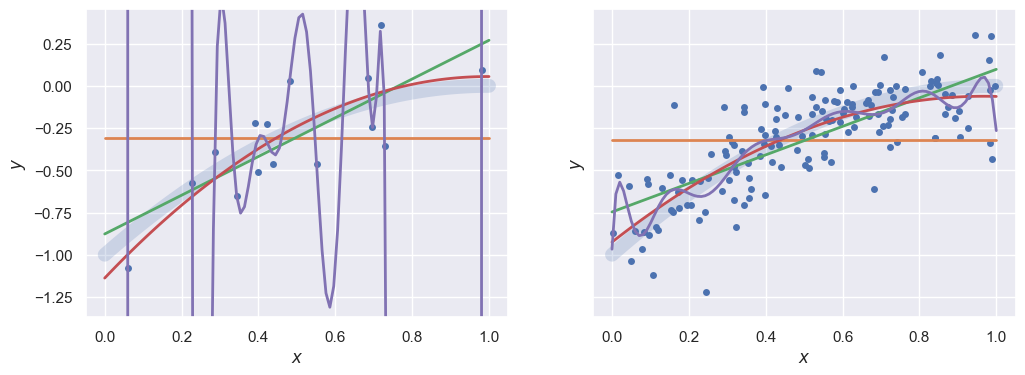

In [25]:
_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
plotXy(Xa, ya, ax[0], poly_fit(Xa, ya, 0), poly_fit(Xa, ya, 1), poly_fit(Xa, ya, 2), poly_fit(Xa, ya, 14))
plotXy(Xb, yb, ax[1], poly_fit(Xb, yb, 0), poly_fit(Xb, yb, 1), poly_fit(Xb, yb, 2), poly_fit(Xb, yb, 14))

### <span style="color:Lightgreen">Train-Test Split</span>

The [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function picks a random fraction of the observed data to hold back when learning the model and then use for latest testing.

Note that since train/test splitting involves random numbers, you will need to pass around a random state object for reproducible results.

The plots below show 20% of the data reserved for testing (red points) with a $P=2$ fit to the training data superimposed. The primary sklearn test metric for regression problems is the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) $R^2$, for which the goal is $R^2 = 1$:

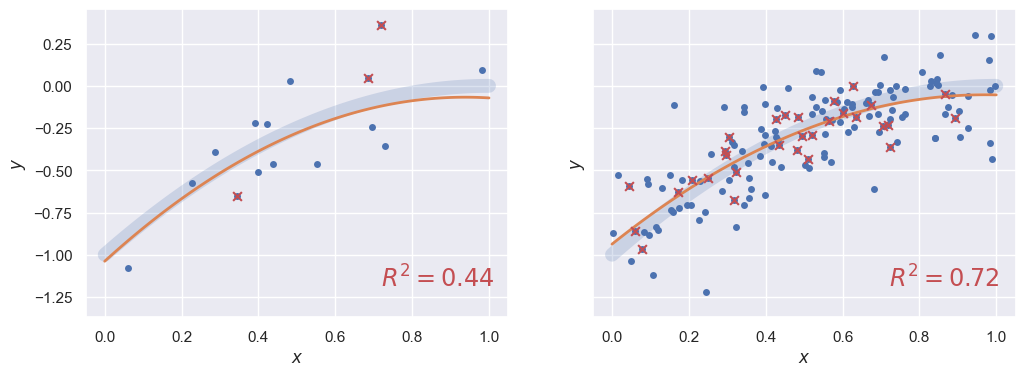

In [26]:
def train_test_split(X, y, degree, test_fraction=0.2, ax=None, seed=123):
    gen = np.random.RandomState(seed=seed)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_fraction, random_state=gen)
    train_fit = poly_fit(X_train, y_train, degree)
    plotXy(X, y, ax, train_fit)
    test_R2 = train_fit.score(X_test.reshape(-1, 1), y_test)
    ax.scatter(X_test, y_test, marker='x', color='r', s=40, zorder=10)
    ax.text(0.7, 0.1, '$R^2={:.2f}$'.format(test_R2), transform=ax.transAxes, fontsize='x-large', color='r')

_, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
train_test_split(Xa, ya, 2, ax=ax[0])
train_test_split(Xb, yb, 2, ax=ax[1])

There is no rigorous procedure for setting an optimum test fraction, and anything between 0.1 and 0.5 would be reasonable (and the sklearn default is 0.25).  A larger test fraction improves the reliability of the test metric but decreases the reliability of the model being tested.  As always, more data always helps and reduces your sensitivity to the training fraction.

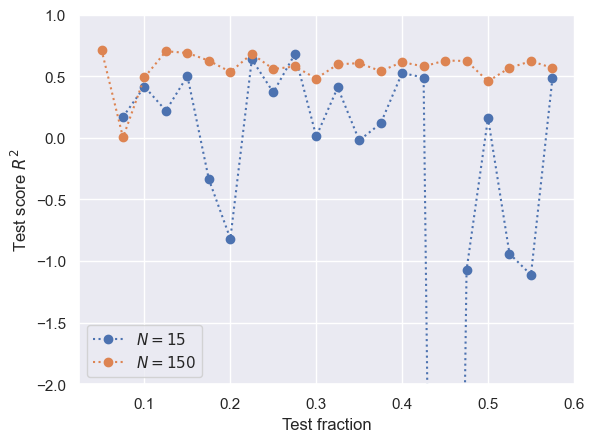

In [27]:
def test_fraction_scan(degree=2, seed=123):
    gen = np.random.RandomState(seed=seed)
    test_fractions = np.arange(0.05, 0.6, 0.025)
    R2 = np.empty((2, len(test_fractions)))
    for i, test_fraction in enumerate(test_fractions):
        for j, (X, y) in enumerate(((Xa, ya), (Xb, yb))):
            X_train, X_test, y_train, y_test = model_selection.train_test_split(
                X, y, test_size=test_fraction, random_state=gen)
            fit = poly_fit(X_train, y_train, degree)
            R2[j, i] = fit.score(X_test.reshape(-1, 1), y_test)
    plt.plot(test_fractions, R2[0], 'o:', label='$N = {}$'.format(len(ya)))
    plt.plot(test_fractions, R2[1], 'o:', label='$N = {}$'.format(len(yb)))
    plt.xlabel('Test fraction')
    plt.ylabel('Test score $R^2$')
    plt.ylim(-2, 1)
    plt.legend()

test_fraction_scan()

### <span style="color:Lightgreen">K-Folding</span>

Cross validation goes beyond a simple train-test split by repeating the split multiple times and combining the (correlated) results. There are different strategies for picking the different splits, but [K-folding](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) is a good all-around choice:
 - Specify the number $k$ of splits (folds) to use.

 - The data is split into $k$ (almost) equal independent subsets.

 - Each subset is used for testing once, with the remaining subsets used for training.

The result is $k$ different train-test splits using a test fraction $1/k$.  For example, with $N=10$ samples and $k=3$ folds, the subsets are:

In [28]:
kfold = model_selection.KFold(n_splits=3)
[tuple(split[1]) for split in kfold.split(range(10))]

[(np.int64(0), np.int64(1), np.int64(2), np.int64(3)),
 (np.int64(4), np.int64(5), np.int64(6)),
 (np.int64(7), np.int64(8), np.int64(9))]

The [cross_validate](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function automates the k-folding and scoring process, and outputs both train and test $R^2$ scores, as well as CPU times, for each split:

In [29]:
def cross_validate(X, y, degree, n_splits):
    model = pipeline.Pipeline([
        ('poly', preprocessing.PolynomialFeatures(degree=degree)),
        ('linear', linear_model.LinearRegression(fit_intercept=True))])
    kfold = model_selection.KFold(n_splits=n_splits)
    scores = model_selection.cross_validate(
        model, X.reshape(-1, 1), y, cv=kfold, return_train_score=True)
    index = [tuple(split[1]) for split in kfold.split(X.reshape(-1, 1))]
    return pd.DataFrame(scores, index=index)

In [30]:
cross_validate(Xa, ya, degree=2, n_splits=3)

,fit_time,score_time,test_score,train_score
"(0, 1, 2, 3, 4)",0.001550,0.000520,0.404038,0.731105
"(5, 6, 7, 8, 9)",0.000856,0.000451,-2.232860,0.632223
"(10, 11, 12, 13, 14)",0.000816,0.000435,-0.352504,0.518438


With enough data, you can use a large number of K-folds but remember that they are highly correlated so you are not increasing the useful information as much as you might think. The sklearn default number of splits is 3.

In [31]:
cross_validate(Xb, yb, degree=2, n_splits=15)

,fit_time,score_time,test_score,train_score
"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0.001790,0.000974,0.574221,0.613270
"(10, 11, 12, 13, 14, 15, 16, 17, 18, 19)",0.001205,0.000543,0.644016,0.608664
"(20, 21, 22, 23, 24, 25, 26, 27, 28, 29)",0.001423,0.000568,0.559857,0.614704
"(30, 31, 32, 33, 34, 35, 36, 37, 38, 39)",0.000984,0.000565,0.382087,0.619587
"(40, 41, 42, 43, 44, 45, 46, 47, 48, 49)",0.000824,0.000424,0.741344,0.601154
"(50, 51, 52, 53, 54, 55, 56, 57, 58, 59)",0.001287,0.000598,0.415899,0.625590
"(60, 61, 62, 63, 64, 65, 66, 67, 68, 69)",0.000936,0.000480,0.675124,0.601310
"(70, 71, 72, 73, 74, 75, 76, 77, 78, 79)",0.000827,0.000449,0.745460,0.599734
"(80, 81, 82, 83, 84, 85, 86, 87, 88, 89)",0.000745,0.000398,0.366792,0.618551
"(90, 91, 92, 93, 94, 95, 96, 97, 98, 99)",0.000753,0.000426,0.498276,0.614549


### <span style="color:Lightgreen">Hyperparameter Grid Search</span>

The [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function puts all the pieces together to scan a grid of one or more hyperparameters for a family of models.  For example, the polynomial degree $P$ corresponds to a pipeline `poly__degree` parameter, which we vary from 0 to 5 below.

In [32]:
def cv_summary(cv):
    """Summarize the results from a GridSearchCV fit.

    Summarize a cross-validation grid search in a pandas DataFrame with the
    following transformations of the full results:
      - Remove all columns with timing measurements.
      - Remove the 'param_' prefix from column names.
      - Remove the '_score' suffix from column names.
      - Round scores to 3 decimal places.

     If the parameter grid is 1D, then this function also plots the test
     and training R2 scores versus the parameter.

    Parameters
    ----------
    cv : sklearn.model_selection.GridSearchCV
        Instance of a GridSearchCV object that has been fit to some data.

    Returns
    -------
    pandas.DataFrame
        Summary table of cross-validation results.
    """
    # Look up the list of parameters used in the grid.
    params = list(cv.cv_results_['params'][0].keys())
    # Index results by the test score rank.
    index = cv.cv_results_['rank_test_score']
    df = pd.DataFrame(cv.cv_results_, index=index).drop(columns=['params', 'rank_test_score'])
    # Remove columns that measure running time.
    df = df.drop(columns=[n for n in df.columns.values if n.endswith('_time')])
    # Remove param_ prefix from column names.
    df = df.rename(lambda n: n[6:] if n.startswith('param_') else n, axis='columns')
    # Remove _score suffix from column names.
    df = df.rename(lambda n: n[:-6] if n.endswith('_score') else n, axis='columns')
    if len(params) == 1:
        # Plot the test and training scores vs the grid parameter when there is only one.
        plt.plot(df[params[0]], df['mean_train'], 'o:', label='train')
        plt.plot(df[params[0]], df['mean_test'], 'o-', label='test')
        plt.legend(fontsize='x-large')
        plt.xlabel('Hyperparameter value')
        plt.ylabel('Score $R^2$')
        plt.ylim(max(-2, np.min(df['mean_test'])), 1)
    return df.sort_index().round(3)

In [33]:
def compare_models(X, y, max_degree=5, n_splits=3, seed=123):
    hyper_grid = {'poly__degree': range(max_degree + 1)}
    hyper_model = pipeline.Pipeline([
        ('poly', preprocessing.PolynomialFeatures()),
        ('linear', linear_model.LinearRegression(fit_intercept=True))])
    kfold = model_selection.KFold(n_splits=n_splits)
    cv = model_selection.GridSearchCV(hyper_model, hyper_grid, cv=kfold, return_train_score=True)
    cv.fit(X.reshape(-1, 1), y)
    return cv_summary(cv)

With a small dataset, a polynomial fit is very prone to overfitting and the training score continues to rise as $P$ increases.  However, only the $P=1$ and $P=2$ models look at all promising on the test data, but are still worse than guessing the average $y$ value (which always has $R^2=0$):

,poly__degree,split0_test,split1_test,split2_test,mean_test,std_test,split0_train,split1_train,split2_train,mean_train,std_train
1,2,0.404,-2.233,-0.353,-0.727,1.109,0.731,0.632,0.518,0.627,0.087
2,1,0.474,-2.819,-0.801,-1.049,1.356,0.621,0.628,0.481,0.577,0.068
3,0,-0.048,-7.549,-3.226,-3.608,3.074,0.000,0.000,0.000,0.000,0.000
4,4,-1.743,-5.019,-28.006,-11.589,11.685,0.857,0.714,0.625,0.732,0.095
5,3,0.408,-51.581,-0.324,-17.166,24.337,0.740,0.708,0.518,0.656,0.098
6,5,-0.837,-316.856,-157.921,-158.538,129.015,0.895,0.716,0.749,0.787,0.077


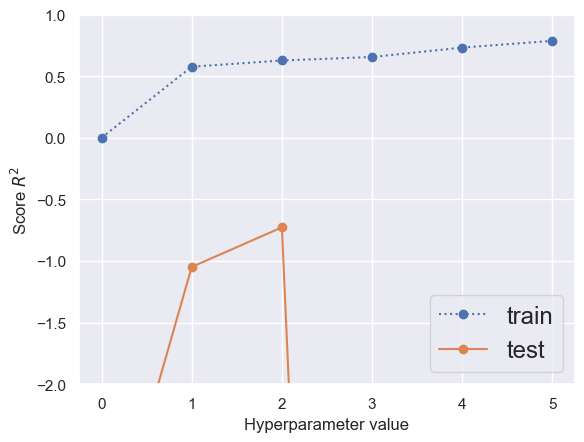

In [34]:
compare_models(Xa, ya)

With a larger dataset, the training score is stable over a wide range of $P\ge 1$ and the test score decreases very slowly. You could make a case for either $P=1$ (less overfitting) or $P=2$ (better test score) from the graph below:

,poly__degree,split0_test,split1_test,split2_test,mean_test,std_test,split0_train,split1_train,split2_train,mean_train,std_train
1,2,0.593,0.600,0.509,0.567,0.041,0.610,0.611,0.638,0.620,0.013
2,3,0.563,0.590,0.512,0.555,0.032,0.619,0.612,0.639,0.623,0.011
3,1,0.607,0.590,0.415,0.537,0.087,0.536,0.540,0.625,0.567,0.041
4,4,0.575,0.584,0.337,0.499,0.114,0.620,0.612,0.688,0.640,0.034
5,5,0.569,0.586,0.336,0.497,0.114,0.623,0.612,0.689,0.642,0.034
6,0,-0.017,-0.023,-0.001,-0.014,0.009,0.000,0.000,0.000,0.000,0.000


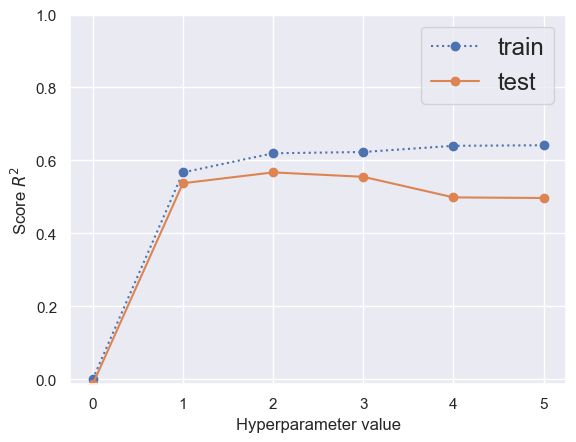

In [35]:
compare_models(Xb, yb)

In [50]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.compat.v2 as tf

%pip install git+https://github.com/google/edward2
import edward2 as ed

  Cloning https://github.com/google/edward2 to /tmp/pip-req-build-ul6sarti
  Running command git clone --filter=blob:none --quiet https://github.com/google/edward2 /tmp/pip-req-build-ul6sarti
  Resolved https://github.com/google/edward2 to commit ee025600cb3cf288230f34929d8a7110e719686b
  Preparing metadata (setup.py) ... done


### <span style="color:Lightgreen">Comparison with the Bayesian Evidence</span>

The function below estimates the Bayesian evidence for the data $D=(X,y)$ given a polynomial model of degree $P$, using the same MCMC techniques we saw earlier. The evidence calculation requires an additional ingredient that we never specified for cross validation: a prior on the $P + 1$ polynomial coefficients, which has a similar effect to a regularization term in an sklearn linear regression.  We adopt a Gaussian prior on each coefficient with the same scale, chosen to be large enough that the likelihood will dominate the posterior.

In [51]:
def create_param_grid(samples, n_grid=50):
    """Create a parameter grid from parameter samples.

    Grids are based on 1D quantiles in each parameter, so are not uniform.

    Parameters
    ----------
    samples : array
        2D array with shape (N, P) containing N samples for P parameters.
    n_grid : int
        Number of grid points to use along each parameter axis.  The full
        grid contains n_grid ** P points.

    Returns
    -------
    array
        Array of shape (n_grid ** P, P) with parameters values covering the
        full grid.  Can be reshaped to ([P] * (P+1)) to reconstruct the
        P-dimensional grid structure.
    """
    samples = np.asarray(samples)
    N, P = samples.shape
    # Create a grid that is equally spaced in quantiles of each column.
    quantiles = np.linspace(0, 100, n_grid)
    grid = [np.percentile(column, quantiles) for column in samples.T]
    # Flatten to an array P-tuples that cover the grid.
    return np.moveaxis(np.stack(
        np.meshgrid(*grid), axis=-1), (0,1), (1,0)).reshape(-1, P)


def estimate_log_evidence(samples, param_grid, log_numerator, max_components=5,
                          grid_fraction=0.1, plot=True, seed=123):
    """Estimate the log evidence using MCMC samples.

    The evidence is estimated at each grid point using the ratio of the
    log_numerator and the empirical density of samples. Only grid points with
    the largest log_numerator are used for the estimate. The density is
    estimated with a Gaussian mixture model using the a number of components
    that minimizes the spread of estimates over the selected grid points.

    Parameters
    ----------
    samples : array
        2D array with shape (N, P) containing N samples for P parameters.
    param_grid : array
        2D array with shape (n_grid ** P, P) to specify a grid that covers
        the full parameter space. Normally obtained by calling
        :func:`create_param_grid`.
    log_numerator : array
        1D array with shape (n_grid ** P,) with the log_likelihood+log_prior
        value tabulated on the input parameter grid.
    max_components : int
        Maximum number of Gaussian mixture model components to use in
        estimating the density of samples over the parameter space.
    grid_fraction : float
        The fraction of grid points with the highest log_numerator to use
        for estimating the log_evidence.
    plot : bool
        When True, draw a scatter plot of log_numerator vs log_evidence for the
        requested fraction of grid points, using the best found number of
        GMM components.
    seed : int or None
        Random seed to use for reproducible results.

    Returns
    -------
    float
        Estimate of the log evidence.
    """
    samples = np.asarray(samples)
    # Only use grid points with the highest log_numerator value.
    cut = np.percentile(log_numerator, 100. * (1 - grid_fraction))
    use = np.where(log_numerator >= cut)[0]
    use_grid = param_grid[use]
    use_log_numerator = log_numerator[use]
    # Loop over the number of GMM components.
    gen = np.random.RandomState(seed=seed)
    log_evidence = np.empty((max_components, len(use)))
    for i in range(max_components):
        # Fit the samples to a Gaussian mixture model.
        fit = mixture.GaussianMixture(
            n_components=i + 1, random_state=gen).fit(samples)
        # Evaluate the density on the grid.
        use_log_density = fit.score_samples(use_grid)
        # Estimate the log(evidence) from each grid point.
        log_evidence[i] = use_log_numerator - use_log_density
    # Calculate the median and 90% spread.
    lo, med, hi = np.percentile(log_evidence, (5, 50, 95), axis=-1)
    spread = 0.5 * (hi - lo)
    best = np.argmin(spread)
    if plot:
        plt.scatter(use_log_numerator, log_evidence[best], s=10, lw=0)
        plt.xlabel('$\log P(D\mid \Theta, M) + \log P(\Theta\mid M)$')
        plt.ylabel('$\log P(D\mid M)$')
        plt.axhline(lo[best], ls='--', c='k')
        plt.axhline(hi[best], ls='--', c='k')
        plt.axhline(med[best], ls='-', c='k')
        plt.title('n_GMM={}, logP(D|M)={:.3f}'.format(best + 1, med[best]))
        plt.show()
    return med[best]

In [52]:
def calculate_evidence(
    Xdata,
    ydata,
    degree,
    sigma_y=sigma_y,
    coef_sigma=10.0,
    n_mc=5000,
    n_grid=50,
    grid_fraction=0.1,
    seed=123,
):
    # Use sklearn fit to initialize MCMC chains
    fit = poly_fit(Xdata, ydata, degree).steps[1][1]
    coef_init = fit.coef_.astype(np.float32)
    if degree > 0:
        coef_init = np.insert(coef_init, 0, fit.intercept_)
    print('Best fit coefficients:', np.round(coef_init, 3))
    P = len(coef_init)

    # Build the graph for this inference
    #
    graph = tf.Graph()
    with graph.as_default():
        tf.random.set_seed(seed)
        np.random.seed(seed)

        # Build the inference model
        #
        X = tf.compat.v1.placeholder(tf.float32, name="X")
        XP = [X ** p for p in range(degree + 1)]
        XX = tf.stack(XP, axis=1, name="XX")

        def model(P, x_data):
            coef = ed.Normal(loc=0.0, scale=tf.fill((P,), coef_sigma), name="coef")
            y_true = tf.reshape(tf.matmul(x_data, tf.reshape(coef, [-1, 1])), [-1])
            y = ed.Normal(loc=y_true, scale=sigma_y, name="y")
            return y

        log_joint = ed.make_log_joint_fn(model)

        def target_log_prob_fn(coef):
            """Target log-probability as a function of states."""
            return log_joint(P, coef=coef, x_data=XX, y=ydata)

        # Define HMC kernel
        #
        num_burnin_steps = 2000
        step_size = 1e-2
        num_leapfrog_steps = 10

        hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=target_log_prob_fn,
            step_size=step_size,
            num_leapfrog_steps=num_leapfrog_steps
        )

        hmc_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=hmc_kernel,
            num_adaptation_steps=int(num_burnin_steps * 0.8)
        )

        # Prepare for MCMC sampling
        #
        def get_shape(n, x):
            x = np.asarray(x)
            return (n, x.shape[0]) if len(x.shape) > 0 else (n,)

        mc_coef = tf.reshape(
            tf.reduce_mean(
                tf.compat.v1.random_normal(get_shape(1000, coef_init),
                                           mean=coef_init),
                axis=0
            ),
            (P,),
        )

        states, kernel_results = tfp.mcmc.sample_chain(
            num_results=n_mc,
            num_burnin_steps=num_burnin_steps,
            current_state=[mc_coef],
            kernel=hmc_kernel
        )

        # Prepare to tabulate log_likelihood + log_prior on a coefficient grid.
        #
        coef_in        = tf.compat.v1.placeholder(tf.float32)
        coef_out       = ed.Normal(loc=0.0, scale=tf.fill(tf.shape(coef_in), coef_sigma))
        y_in           = tf.compat.v1.placeholder(tf.float32)
        y_true_out     = tf.transpose(tf.matmul(XX, tf.transpose(coef_in)))
        y_out          = ed.Normal(loc=y_true_out, scale=sigma_y)
        log_likelihood = tf.reduce_sum(y_out.distribution.log_prob(y_in), axis=-1)
        log_prior      = tf.reduce_sum(coef_out.distribution.log_prob(coef_in), axis=-1)
        log_numerator  = log_likelihood + log_prior

        init_op = tf.compat.v1.global_variables_initializer()

    with tf.compat.v1.Session(graph=graph) as sess:
        # Run the inference using HMC to generate samples.
        #
        init_op.run()
        states_, results_ = sess.run([states, kernel_results], feed_dict={X: Xdata})
        coef_samples = states_[0]

        # Build a parameter grid for estimating the evidence.
        #
        coef_grid = create_param_grid(coef_samples, n_grid=n_grid)

        # Evaluate log(likelihood) + log(prior) on the parameter grid.
        #
        log_numerator_grid = sess.run(
            log_numerator, feed_dict={X: Xdata, y_in: ydata, coef_in: coef_grid}
        )

    return estimate_log_evidence(
        coef_samples, coef_grid, log_numerator_grid, grid_fraction=grid_fraction
    )

Best fit coefficients: [-0.31]


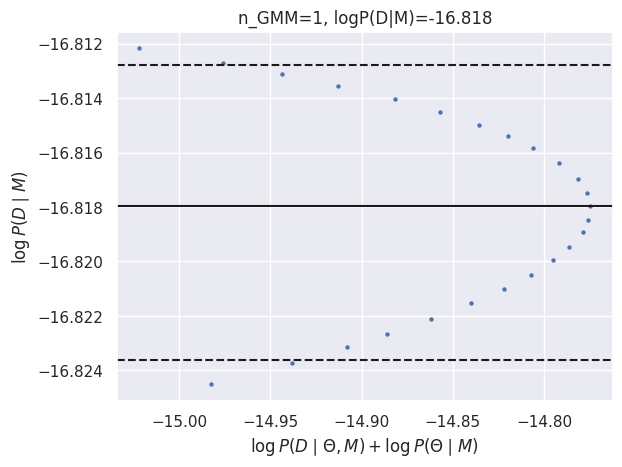

In [53]:
log_Ea_P0 = calculate_evidence(Xa, ya, 0, grid_fraction=0.5)

Best fit coefficients: [-0.318]


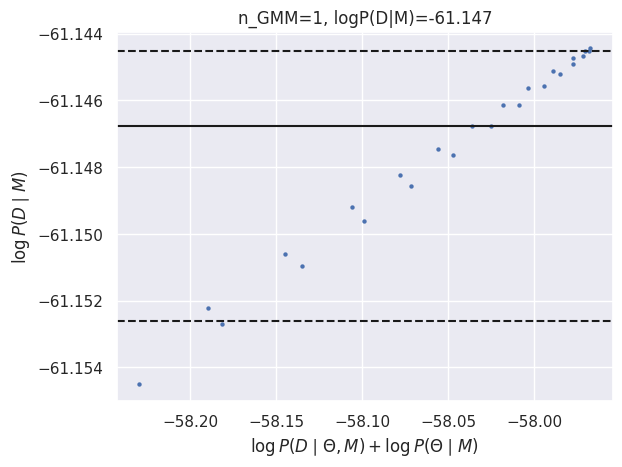

In [54]:
log_Eb_P0 = calculate_evidence(Xb, yb, 0, grid_fraction=0.5)

Best fit coefficients: [-0.877  1.147]


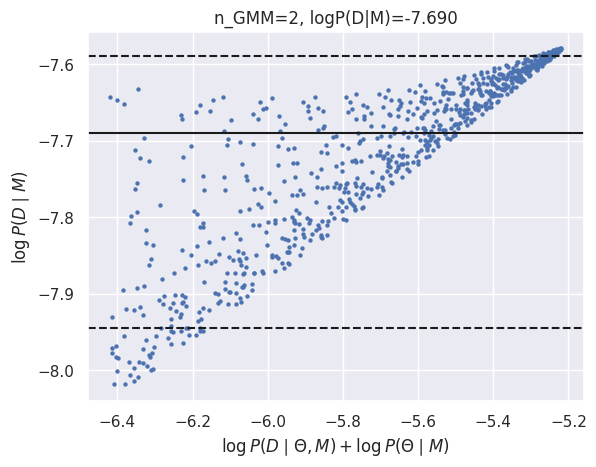

In [55]:
log_Ea_P1 = calculate_evidence(Xa, ya, 1, grid_fraction=0.3)

Best fit coefficients: [-0.747  0.845]


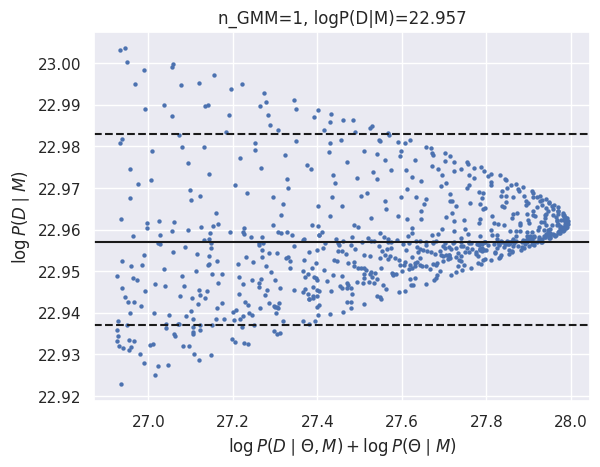

In [56]:
log_Eb_P1 = calculate_evidence(Xb, yb, 1, grid_fraction=0.3)

Best fit coefficients: [-1.138  2.396 -1.202]


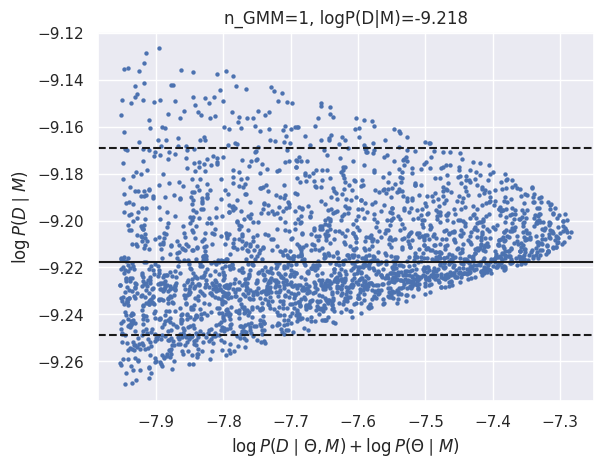

In [57]:
log_Ea_P2 = calculate_evidence(Xa, ya, 2, grid_fraction=0.02)

Best fit coefficients: [-0.925  1.787 -0.925]


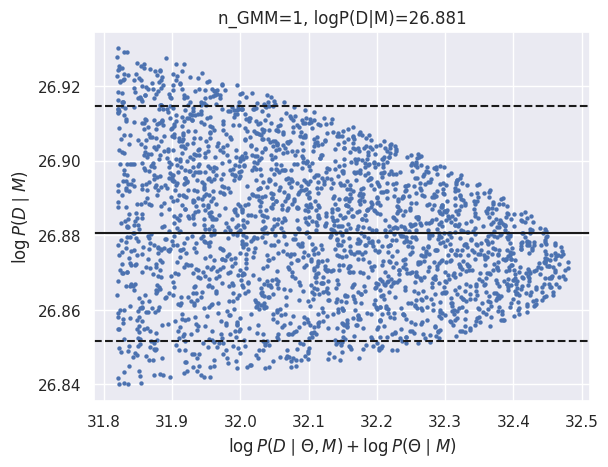

In [58]:
log_Eb_P2 = calculate_evidence(Xb, yb, 2, grid_fraction=0.02)

Best fit coefficients: [-1.24   3.377 -3.495  1.48 ]


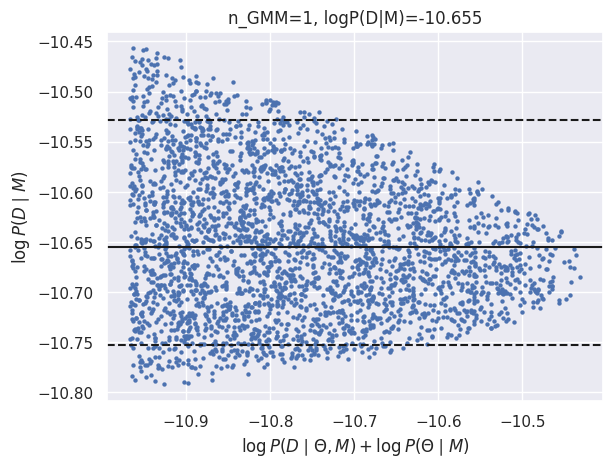

In [59]:
log_Ea_P3 = calculate_evidence(Xa, ya, 3, grid_fraction=0.0005)

Best fit coefficients: [-0.892  1.44  -0.097 -0.54 ]


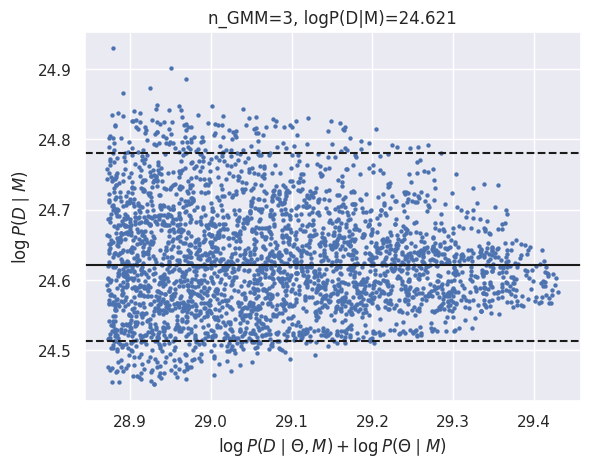

In [60]:
log_Eb_P3 = calculate_evidence(Xb, yb, 3, grid_fraction=0.0005)

Summarize these estimated log evidence values, $\log P(D\mid M)$, for the four models considered, P0-3:

In [61]:
results = pd.DataFrame({
    'P0': [log_Ea_P0, log_Eb_P0], 'P1': [log_Ea_P1, log_Eb_P1],
    'P2': [log_Ea_P2, log_Eb_P2], 'P3': [log_Ea_P3, log_Eb_P3]},
    index=('N=15', 'N=150'))
results.round(2)

,P0,P1,P2,P3
N=15,-16.82,-7.69,-9.22,-10.66
N=150,-61.15,22.96,26.88,24.62


___<span style="color:violet">EXERCISE</span>___: Use the table of $\log P(D\mid M)$ values above to answer the following questions:
 - Which model best explains the $N=15$ dataset?

 - Which model best explains the $N=150$ dataset?

 - Which pairs of models have a Bayes' factor $> 100$, indicating "decisive evidence" favoring one model over the other?

 - Does "decisive evidence" that favors one model over another indicate that the favored model is correct?

 - Are the model comparisons based on evidence substantially different from those based on cross validation in this example?

The $N=15$ dataset is best explained by the P1 model (since it has the maximum value in the first row of the table).

The $N=150$ dataset is best explained by the P2 model (since it has the maximum value in the first row of the table).

A Bayes' factor $> 100$ corresponds to a difference in $\log P(D\mid M)$ of $\log 100 \simeq 4.6$.

Here is a table showing which model pairs pass this test for $N=15$:

In [62]:
row = results.iloc[0].values
print(np.exp(row - row.reshape(-1, 1)) > 100)

[[False  True  True  True]
 [False False False False]
 [False False False False]
 [False False False False]]


And for $N=150$:

In [63]:
row = results.iloc[1].values
print(np.exp(row - row.reshape(-1, 1)) > 100)

[[False  True  True  True]
 [False False False False]
 [False False False False]
 [False False False False]]


We find that, in both cases, the P1, P2, and P3 models are all "decisively favored" over P0 as explanations for the data.

The Bayes' factor is calculated for a pair of models, without considering the range of all possible models. A high value can either indicate that one model of the pair is particularly good or that the other model is particularly bad (or some combination of these). In this example, P0 is particularly bad. In general, the Bayes' factor compares models relative to each other, but does not offer any absolute measure of how well either model explains the data.

These evidence-based model comparisons are broadly consistent with the earlier cross-validation comparisons, but with some differences in the details. The advantages of using evidence are clearer for the smaller dataset, where the cross validation results are difficult to interpret and priors have more influence. Ideally, you should use both methods and compare.

---
## <span style="color:Orange">Acknowledgments</span>

* Initial version: Mark Neubauer

© Copyright 2025